In [1]:
import numpy as np 
import bottleneck as bn
import math 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="whitegrid")
from scipy import stats
import scipy 
plt.rcParams["figure.figsize"] = (13,10)


df = pd.read_csv("stock_prices_SP500_2007_2021.csv")
df.set_index("time", inplace = True)
#loss 
df = -np.log(df/df.shift(1)) 
na = (df.isnull().sum(axis = 0) > 300)
todrop = list(na.loc[na == True].index)
df.drop(columns = todrop, inplace = True)
date = df.index.to_numpy()
df.fillna(0, inplace = True)
df_n = df.to_numpy()
n_col = df_n.shape[1]
window = 250
theta = np.array([0,0.1,0.3,0.5])

In [2]:
#Alternative Method
#calculating also the correlation using a rolling window

def get_breaches_CI(obs, p, alpha):
    lower = scipy.stats.binom.ppf((p+1)/2, obs, alpha)
    upper = scipy.stats.binom.ppf((1-p)/2, obs, alpha)
    return lower, upper 

def p_value(x,obs, alpha):
    p_value = 1 - scipy.stats.binom.cdf(x, obs, alpha)
    return np.round(p_value,4) 

def generate_q(seed, dim=580):
    np.random.seed(seed)
    q = np.random.randint(low = -5, high=5, size=dim)
    return np.squeeze(q)


def calculate_shrunked_cov(theta, window_std, window_cor):
        covariances = []
        window = window_cor 

        if window_std == window_cor:
            for j in range(0, df_n.shape[0]-window):
                x = df_n[j:j+window,:]
                covariance = np.cov(x.T)
                correlation = np.diag(covariance)**(-1) * covariance 
                shrunked = (1-theta)*correlation + (theta)*np.identity(covariance.shape[0])
                covariances.append(np.diag(covariance) * shrunked)
        else:
            std_ = [ np.std(df_n[j:j+window_std,:], axis = 0) for j in range(window_cor - window_std, df_n.shape[0]-window_std)] 

            for j in range(0, df_n.shape[0] - window_cor):
                x = df_n[j:j+window,:]
                covariance = np.cov(x.T)
                correlation = np.diag(covariance)**(-1) * covariance 
                shrunked = (1-theta)*correlation + (theta)*np.identity(covariance.shape[0])
                covariances.append(std_[j]**2 * shrunked)
            print(len(std_), len(covariances))
        
        return covariances
    


2603 2603


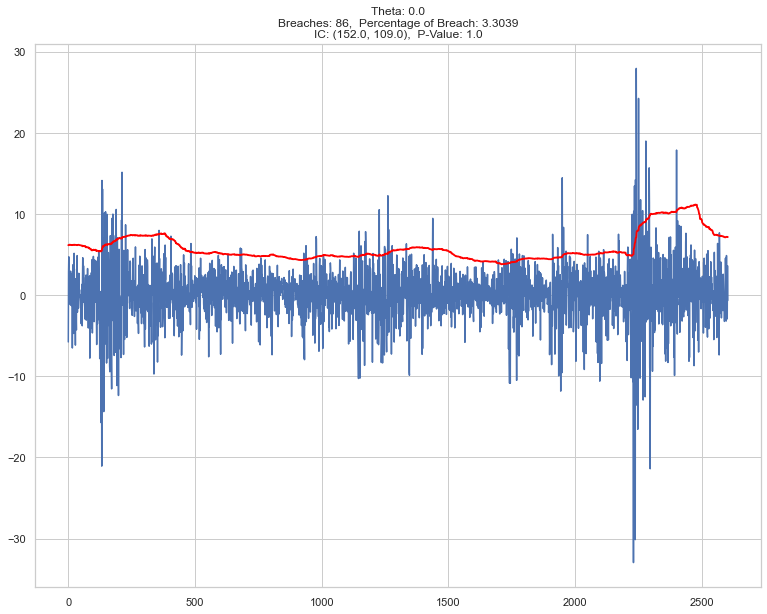

KeyboardInterrupt: 

In [4]:
q =generate_q(seed = 300, dim = df_n.shape[1])

def shrunk_var(t, window_std, window_cor, level = 0.95):
        window = window_cor
        cov_nump = np.array(calculate_shrunked_cov(t, window_std, window_cor))
        Variance_portfolio = np.squeeze(q.T @ cov_nump @ q)
        portfolio =  df_n @ q
        quantile = scipy.stats.norm.ppf(level)
        mean_rolling = [ np.mean(portfolio[j:j+window_std], axis = 0) for j in range(window_cor - window_std, df_n.shape[0]-window_std)] 
        portfolio = np.squeeze(portfolio[window:]) 
        var = Variance_portfolio**0.5 * quantile + np.array(mean_rolling)
        
        exception = np.round(np.sum(1*(portfolio > var))/len(portfolio) * 100, 4)
        
        plt.plot(portfolio)
        plt.plot(var, color = "red", linewidth = 1.85)
        plt.title(f"Theta: {t}\nBreaches: {(portfolio > var).sum()},  Percentage of Breach: {exception}\nIC: {get_breaches_CI(len(var), 0.95, 1 -level )},  P-Value: {p_value((portfolio > var).sum(), len(portfolio), 0.05)}")
        name = f"Theta_{t}_{window_std}_{window_cor}_{level}.png"
        plt.savefig(name, bbox_inches='tight')
        plt.show()

        
[shrunk_var(t=t, window_std = 250, window_cor = 1000) for t in theta]

In [ ]:
#alternative method 
# def generate_q(seed, dim=580):
#     np.random.seed(seed)
#     q = np.random.random((dim,1))
#     return q

# def rolling_std(x, window):
#     return x.rolling(window).std()

# rolling_std_ = rolling_std(df, window)

# def mean_var(x, q, theta, level):
#     cov = (x**2).to_numpy() * (cor*(1-theta) + ind*theta)
#     quantile = scipy.stats.norm.ppf(0.95)
#     return  (q.transpose() @ cov @ q)**(1/2) * quantile

# def var(q, theta, mu, level=0.95):
#     m_v = rolling_std_.apply(func = lambda x: mean_var(x, q, theta, level), axis = 1 )
#     return  m_v + mu

# q = generate_q(seed = 100, dim = len(df.columns)) 
# portfolio = (np.squeeze(q)*df).sum(axis = 1)
# mu = portfolio.rolling(window).mean()
# theta = [0, 0.1, .3, 0.5]

# for t in theta:
#   var_ = var(q, t, mu)
#   exception = (portfolio > var_).sum()/len(portfolio) * 100
#   plt.plot(portfolio.to_numpy())
#   plt.plot(var_.to_numpy(), color = "red", linewidth = 1.85)
#   plt.title(f"Theta: {t}\nPercentage of Breach: {exception}")
#   plt.show()

# #try to generate the q in different ways allowing also for negative values : shorting

5.5292